<a href="https://colab.research.google.com/github/simoa-ufmg/adaptdominio/blob/main/NNCloro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Water

In [ ]:
!pip install adapt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 99 kB 4.7 MB/s 
  Created wheel for adapt: filename=adapt-0.4.2-py3-none-any.whl size=129084 sha256=00b0cef1fff6ecede948a8a64fd1b9e1144414749e6ddf44c744116f858b273a
  Stored in directory: /root/.cache/pip/wheels/f8/a4/a8/3b643882a85773a86adc0b5b6e7efd2e2a4583de11e5598b1e
Successfully built adapt


In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from collections import Counter
from numpy import where

In [ ]:
import os

import adapt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise, BatchNormalization
from tensorflow.keras.constraints import MinMaxNorm
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score

# import SVC classifier
from sklearn.svm import SVC
# import metrics to compute accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score

from adapt.feature_based import DANN, ADDA, DeepCORAL, CORAL, MCD, MDD, WDGRL, CDAN, FA, SA,fMMD, CCSA
from adapt.instance_based import KMM, LDM, KLIEP, WANN
from adapt.parameter_based import RegularTransferLR, RegularTransferNN, RegularTransferLC, FineTuning, TransferTreeClassifier, TransferForestClassifier

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#url3 ='https://raw.githubusercontent.com/MaurenSguarioUTFPR/Cemig/main/Turbidez_Pixels_Captura_S2_Dados_Globais_13_Datasets.csv'
url3 = 'https://raw.githubusercontent.com/MaurenSguarioUTFPR/Cemig/main/Clorofila_Pixels_Captura_S2_Dados_Globais_13_Datasets.csv'

data3  = pd.read_csv(url3, header=0, index_col=False, na_values='.');

columns = ["Unnamed: 0" ,"Sample_Date", "Image_Date", "Time_Sample", "Image_Hour", "Station_Sample", "Parameter", "Value", "Unit", "Depth", "Depth_Unit", "Local_Name", "Location_Type", "Lat", "Lon", "Country", "Organization_Data", "Hemisphere", "Season", "Source_Domain", "Diff_Date", "BAND_1", "BAND_2", "BAND_3", "BAND_4", "BAND_5", "BAND_6", "BAND_7", "BAND_8", "BAND_8A", "BAND_9", "BAND_11", "BAND_12", "MSK_CLDPRB", "MSK_SNOW", "QA60", "CLDYPXPER", "DRK_FEA_PE", "NDWI", "NBSI", "Water_Check", "Snow_Check", "Scene_Class", "geometry"]
data3.columns = columns

In [ ]:
#dados = data3.loc[data3['Country'] == 'US']
USA = data3.loc[data3['Source_Domain'] == 'United_States']
Canada = data3.loc[data3['Source_Domain'] == 'Canada']

In [ ]:
usa = USA.loc[(USA['MSK_CLDPRB'] <= 0.0) & (USA['MSK_SNOW'] <= 0.0) & (USA['Scene_Class'] == "Water") & (USA['Water_Check'] != "Drought") & (USA['Snow_Check'] == "No_Snow") & (USA['QA60'] <= 0.0)]
canada = Canada.loc[(Canada['MSK_CLDPRB'] <= 0.0) & (Canada['MSK_SNOW'] <= 0.0) & (Canada['Scene_Class'] == "Water") & (Canada['Water_Check'] != "Drought") & (Canada['Snow_Check'] == "No_Snow") & (Canada['QA60'] <= 0.0)]

In [ ]:
mult = 3

std_reference = usa['Value'].std() * mult
lower_std = usa['Value'].mean() - std_reference
upper_std = usa['Value'].mean() + std_reference

In [ ]:
def std_outlier(x):
    if ((x >= lower_std) & (x<=upper_std)):
        return 1
    else:
        return -1

In [ ]:
usa['anomalies_std'] = usa['Value'].apply(std_outlier)
usa = usa.query('anomalies_std == 1')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
del(usa['anomalies_std'])

In [ ]:
usa = usa.drop_duplicates(['BAND_1','BAND_2','BAND_3'])
canada = canada.drop_duplicates(['BAND_1','BAND_2','BAND_3'])
usa = usa.loc[(usa['Diff_Date'] <= 0)]
canada = canada.loc[(canada['Diff_Date'] <= 2)]

In [ ]:
usaT = usa.loc[(usa['Parameter'] == "Chlorophyll")]
canadaT = canada.loc[(canada["Parameter"] == "Chlorophyll")]

In [ ]:
usaT = usaT.drop(['Unnamed: 0'], axis=1)
usaT = usaT.drop(['Time_Sample'], axis=1)
usaT = usaT.drop(['Image_Hour'], axis=1)
usaT = usaT.drop(['Station_Sample'], axis=1)
usaT = usaT.drop(['Sample_Date'], axis=1)
usaT = usaT.drop(['Image_Date'], axis=1)
usaT = usaT.drop(['Parameter'], axis=1)
usaT = usaT.drop(['Unit'], axis=1)
usaT = usaT.drop(['Depth'], axis=1)
usaT = usaT.drop(['Depth_Unit'], axis=1)
usaT = usaT.drop(['Local_Name'], axis=1)
usaT = usaT.drop(['Location_Type'], axis=1)
usaT = usaT.drop(['Country'], axis=1)
usaT = usaT.drop(['Organization_Data'], axis=1)
usaT = usaT.drop(['Hemisphere'], axis=1)

In [ ]:
usaT = usaT.drop(['Season'], axis=1)
usaT = usaT.drop(['Source_Domain'], axis=1)
usaT = usaT.drop(['Diff_Date'], axis=1)
usaT = usaT.drop(['MSK_CLDPRB'], axis=1)
usaT = usaT.drop(['MSK_SNOW'], axis=1)
usaT = usaT.drop(['CLDYPXPER'], axis=1)
usaT = usaT.drop(['QA60'], axis=1)
usaT = usaT.drop(['DRK_FEA_PE'], axis=1)
usaT = usaT.drop(['NDWI'], axis=1)
usaT = usaT.drop(['NBSI'], axis=1)
usaT = usaT.drop(['Water_Check'], axis=1)
usaT = usaT.drop(['Snow_Check'], axis=1)
usaT = usaT.drop(['Scene_Class'], axis=1)
usaT = usaT.drop(['geometry'], axis=1)


# Dados 

In [ ]:
def classifica_uso_residencial_malasia(x):
        if x <= 25:
            return "0"
        else:
            return '1'

In [ ]:
usaT['Classe'] = usaT['Value'].apply(classifica_uso_residencial_malasia)

Pitsburg long -79.995888   lat 40.440624
Chicago  long -87.623177   lat 41.881832
Denver   long -104.991531  lat 39.742043
Miami    long -80.191788   lat 25.761681

# Dataset 80 treino 20 teste

In [ ]:
Xt = usaT[usaT['Lon'] < -90.991531]
Xs = usaT[usaT['Lon'] >= -90.991531]

In [ ]:
Xs = Xs.fillna(Xs.median(numeric_only=True))
Xt = Xt.fillna(Xt.median(numeric_only=True))

In [ ]:
Xs = Xs.drop(['Value'], axis=1)
Xs = Xs.drop(['Lat'], axis=1)
Xs = Xs.drop(['Lon'], axis=1)

In [ ]:
Xt = Xt.drop(['Value'], axis=1)
Xt = Xt.drop(['Lat'], axis=1)
Xt = Xt.drop(['Lon'], axis=1)

In [ ]:
bandas = ['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12']
Xs[bandas] = Xs[bandas].multiply(0.0001)
Xt[bandas] = Xt[bandas].multiply(0.0001)

In [ ]:
array = Xs.values
Xs = array[:, 0:12].astype(float)
ys = array[:, 12].astype(int)

In [ ]:
array = Xt.values
Xt = array[:, 0:12].astype(float)
yt = array[:, 12].astype(int)

In [ ]:
print("train_set size: {} - Class0: {}, Class1: {}, Class2: {}".format( len(ys), len(ys[ys == 0]), len(ys[ys == 1]), len(ys[ys == 2]) ))
print("test_set size: {} - Class0: {}, Class1: {}, Class2: {}".format( len(yt), len(yt[yt == 0]), len(yt[yt == 1]), len(yt[yt == 2]) ))

train_set size: 2534 - Class0: 2111, Class1: 423, Class2: 0
test_set size: 1960 - Class0: 1503, Class1: 457, Class2: 0


#Smote

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from numpy import where
from matplotlib import pyplot

In [ ]:
# transform the dataset train
oversample = SMOTE()
Xs, ys = oversample.fit_resample(Xs, ys)

In [ ]:
print("train_set size: {} - Class0: {}, Class1: {}, Class2: {}, Class3: {}".format( len(ys), len(ys[ys == 0]), len(ys[ys == 1]), len(ys[ys == 2]), len(ys[ys == 3]) ))
print("test_set size: {} - Class0: {}, Class1: {}, Class2: {}, Class3: {}".format( len(yt), len(yt[yt == 0]), len(yt[yt == 1]), len(yt[yt == 2]), len(yt[yt == 3]) ))

train_set size: 4222 - Class0: 2111, Class1: 2111, Class2: 0, Class3: 0
test_set size: 1960 - Class0: 1503, Class1: 457, Class2: 0, Class3: 0


#Results

In [ ]:
std_sc = StandardScaler().fit(np.concatenate((Xs, Xt)))
Xs = std_sc.transform(Xs)
Xt = std_sc.transform(Xt)

In [ ]:
def show_results2(model, is_src_only=False):
  
  ys_pred = model.predict(Xs)
  yt_pred = model.predict(Xt)
  acc_s = accuracy_score(ys, ys_pred>0.5)
  acc_t = accuracy_score(yt, yt_pred>0.5)


  cmT = confusion_matrix(yt, yt_pred>0.5)
  cm_display = ConfusionMatrixDisplay(cmT).plot()
  

  print(classification_report(yt, yt_pred))  
  
  if is_src_only:
  
    print("Accuracy, source : %f" % acc_s)
    print("Balanced accuracy, source : %f" % balanced_accuracy_score(ys, ys_pred>0.5))
    print("Precision, source: %f" % precision_score(ys, ys_pred>0.5))
    print("Recall, source: %f" % recall_score(ys, ys_pred>0.5))
    print("F1, source: %f" % f1_score(ys, ys_pred>0.5))
    print("Area under curve (auc):, source: %f" % roc_auc_score(ys, ys_pred>0.5))
    print("Accuracy, target : %f" % acc_t)
    print("Balanced accuracy, target : %f" % balanced_accuracy_score(yt, yt_pred>0.5))
    print("Precision, target: %f" % precision_score(yt, yt_pred>0.5))
    print("Recall, target: %f" % recall_score(yt, yt_pred>0.5))
    print("F1, target: %f" % f1_score(yt, yt_pred>0.5))
    print("Area under curve (auc):, target: %f" % roc_auc_score(yt, yt_pred>0.5))
  else: 
    
    print("Accuracy, source : %f" % acc_s)
    print("Balanced accuracy, source : %f" % balanced_accuracy_score(ys, ys_pred>0.5))
    print("Precision, source: %f" % precision_score(ys, ys_pred>0.5))
    print("Recall, source: %f" % recall_score(ys, ys_pred>0.5))
    print("F1, source: %f" % f1_score(ys, ys_pred>0.5))
    print("Area under curve (auc):, source: %f" % roc_auc_score(ys, ys_pred>0.5))
    print("Accuracy, target : %f" % acc_t)
    print("Balanced accuracy, target : %f" % balanced_accuracy_score(yt, yt_pred>0.5))
    print("Precision, target: %f" % precision_score(yt, yt_pred>0.5))
    print("Recall, target: %f" % recall_score(yt, yt_pred>0.5))
    print("F1, target: %f" % f1_score(yt, yt_pred>0.5))
    print("Area under curve (auc):, target: %f" % roc_auc_score(yt, yt_pred>0.5))
 


In [ ]:
def show_results(model, is_src_only=False):
  
  ys_pred = model.predict(Xs)
  yt_pred = model.predict(Xt)
  acc_s = accuracy_score(ys, ys_pred>0.5)
  acc_t = accuracy_score(yt, yt_pred>0.5)

  print(classification_report(yt, yt_pred>0.5))

  if is_src_only:
    print("ok")
    print("Accuracy, source : %f" % acc_s)
    print("Balanced accuracy, source : %f" % balanced_accuracy_score(ys, ys_pred>0.5))
    print("Precision, source: %f" % precision_score(ys, ys_pred>0.5))
    print("Recall, source: %f" % recall_score(ys, ys_pred>0.5))
    print("F1, source: %f" % f1_score(ys, ys_pred>0.5))
    print("Area under curve (auc):, source: %f" % roc_auc_score(ys, ys_pred>0.5))
    print("Accuracy, target : %f" % acc_t)
    print("Balanced accuracy, target : %f" % balanced_accuracy_score(yt, yt_pred>0.5))
    print("Precision, target: %f" % precision_score(yt, yt_pred>0.5))
    print("Recall, target: %f" % recall_score(yt, yt_pred>0.5))
    print("F1, target: %f" % f1_score(yt, yt_pred>0.5))
    print("Area under curve (auc):, target: %f" % roc_auc_score(yt, yt_pred>0.5))
  else:  
    cmT = confusion_matrix(yt, yt_pred>0.5)
    print("Accuracy, target : %f" % acc_t)
    print("Balanced accuracy, target : %f" % balanced_accuracy_score(yt, yt_pred>0.5))
    #print("Precision, target: %f" % precision_score(yt, yt_pred>0.5, average='weighted'))
    print("Precision, target: %f" % precision_score(yt, yt_pred>0.5))
    print("Recall, target: %f" % recall_score(yt, yt_pred>0.5))
    print("F1, target: %f" % f1_score(yt, yt_pred>0.5))

  
  yp_grid = model.predict(X_grid).reshape(100, 100)

  Xs_enc = model.transform(Xs)
  Xt_enc = model.transform(Xt)
  pca_enc = PCA(2).fit(np.concatenate((Xs_enc, Xt_enc)))
  Xs_enc_pca = pca_enc.transform(Xs_enc)
  Xt_enc_pca = pca_enc.transform(Xt_enc)

  cm = plt.cm.RdBu
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

  ax1.set_title("PCA input space")
  ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
  ax1.scatter(Xs_pca[ys==0, 0], Xs_pca[ys==0, 1], label="source", edgecolors='k', c="red")
  ax1.scatter(Xs_pca[ys==1, 0], Xs_pca[ys==1, 1], label="source", edgecolors='k', c="blue")
  ax1.scatter(Xt_pca[:, 0], Xt_pca[:, 1], label="target", edgecolors='k', c="black", alpha=0.5)
  ax1.legend()
  ax1.set_yticklabels([])
  ax1.set_xticklabels([])
  ax1.tick_params(direction ='in')

  ax2.set_title("PCA encoded space")
  ax2.scatter(Xs_enc_pca[ys==0, 0], Xs_enc_pca[ys==0, 1], label="source", edgecolors='k', c="red")
  ax2.scatter(Xs_enc_pca[ys==1, 0], Xs_enc_pca[ys==1, 1], label="source", edgecolors='k', c="blue")
  ax2.scatter(Xt_enc_pca[:, 0], Xt_enc_pca[:, 1], label="target", edgecolors='k', c="black", alpha=0.5)
  ax2.set_yticklabels([])
  ax2.set_xticklabels([])
  ax2.tick_params(direction ='in')
  if is_src_only:
    fig.suptitle("%s - Source Acc : %.3f - Target Acc : %.3f"%("Source Only", acc_s, acc_t))
  else:
    fig.suptitle("%s - Source Acc : %.3f - Target Acc : %.3f"%(model.__class__.__name__, acc_s, acc_t))
  plt.show()

# Network

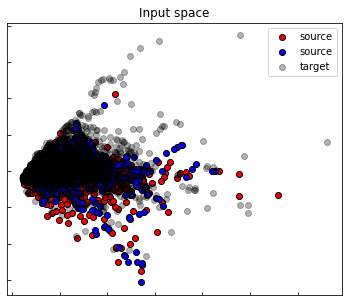

In [ ]:
pca = PCA(2).fit(np.concatenate((Xs, Xt)))
Xs_pca = pca.transform(Xs)
Xt_pca = pca.transform(Xt)

x_min, y_min = np.min([Xs_pca.min(0), Xt_pca.min(0)], 0)
x_max, y_max = np.max([Xs_pca.max(0), Xt_pca.max(0)], 0)
x_grid, y_grid = np.meshgrid(np.linspace(x_min-0.1, x_max+0.1, 100),
                             np.linspace(y_min-0.1, y_max+0.1, 100))
X_grid = pca.inverse_transform(np.stack([x_grid.ravel(), y_grid.ravel()], -1))

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title("Input space")
ax1.scatter(Xs_pca[ys==0, 0], Xs_pca[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs_pca[ys==1, 0], Xs_pca[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt_pca[:, 0], Xt_pca[:, 1], label="target", edgecolors='k', c="black", alpha=0.3)
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')
plt.show()

In [ ]:
def get_task(activation="sigmoid", units=1):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(10, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(units, activation=activation))
    return model

<a name="Source-Only"></a>
# Source Only

For source only, we use a DANN instance with lambda set to zero. Thus, the gradient of the discriminator is not back-propagated through the encoder.

In [ ]:
src_only = DANN(task=get_task(),
                loss="bce", optimizer=Adam(0.001, beta_1=0.5),
                copy=True, lambda_=0., metrics=["acc"], random_state=0)

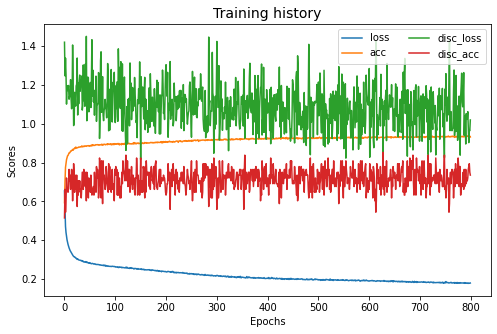

In [ ]:
src_only.fit(Xs, ys, Xt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(src_only.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1503
           1       0.64      0.78      0.71       457

    accuracy                           0.85      1960
   macro avg       0.79      0.83      0.80      1960
weighted avg       0.86      0.85      0.85      1960

ok
Accuracy, source : 0.935576
Balanced accuracy, source : 0.935576
Precision, source: 0.935163
Recall, source: 0.936049
F1, source: 0.935606
Area under curve (auc):, source: 0.935576
Accuracy, target : 0.847959
Balanced accuracy, target : 0.825484
Precision, target: 0.642729
Recall, target: 0.783370
F1, target: 0.706114
Area under curve (auc):, target: 0.825484
62/62 [==============================] - 0s 1ms/step


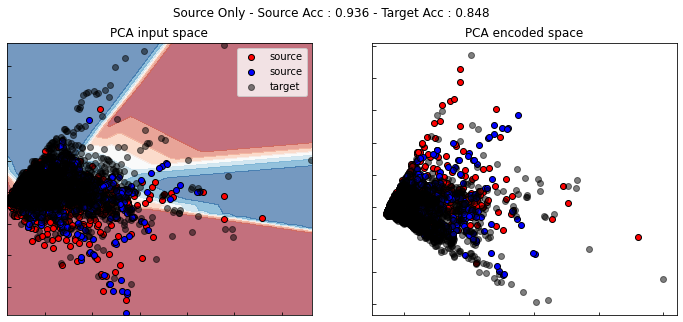

In [ ]:
show_results(src_only, True)

In [ ]:
src_only.score(Xt, yt)

1/1 [==============================] - 0s 170ms/step - loss: 0.6160 - acc: 0.8480


0.6160460710525513

FA

In [ ]:
fa = FA(estimator=get_task(), Xt=Xt[:10], yt=yt[:10],loss="bce", optimizer=Adam(0.001, beta_1=0.5), random_state=0)

In [ ]:
fa.fit(Xs, ys, epochs=800, batch_size=34, verbose=0);

Fit transform...
Previous shape: (4222, 12)
New shape: (4232, 36)
Fit Estimator...


              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1503
           1       0.53      0.68      0.59       457

    accuracy                           0.78      1960
   macro avg       0.71      0.75      0.72      1960
weighted avg       0.81      0.78      0.79      1960

ok
Accuracy, source : 0.685694
Balanced accuracy, source : 0.685694
Precision, source: 0.834471
Recall, source: 0.463288
F1, source: 0.595797
Area under curve (auc):, source: 0.685694
Accuracy, target : 0.782653
Balanced accuracy, target : 0.747877
Precision, target: 0.526138
Recall, target: 0.682713
F1, target: 0.594286
Area under curve (auc):, target: 0.747877


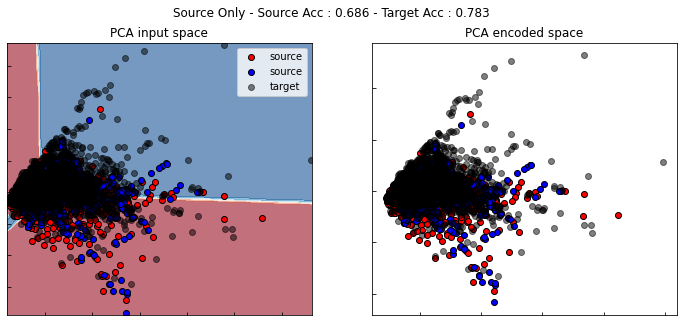

In [ ]:
show_results(fa, True) 

SA

In [ ]:
sa = SA(estimator=get_task(), Xt=Xt, loss="bce", optimizer=Adam(0.001, beta_1=0.5), random_state=0)
sa.fit(Xs, ys, epochs=800, batch_size=34, verbose=0);

Fit transform...
Fit Estimator...


              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1503
           1       0.58      0.85      0.69       457

    accuracy                           0.82      1960
   macro avg       0.76      0.83      0.78      1960
weighted avg       0.86      0.82      0.83      1960

ok
Accuracy, source : 0.876125
Balanced accuracy, source : 0.876125
Precision, source: 0.879541
Recall, source: 0.871625
F1, source: 0.875565
Area under curve (auc):, source: 0.876125
Accuracy, target : 0.823469
Balanced accuracy, target : 0.831597
Precision, target: 0.583710
Recall, target: 0.846827
F1, target: 0.691071
Area under curve (auc):, target: 0.831597


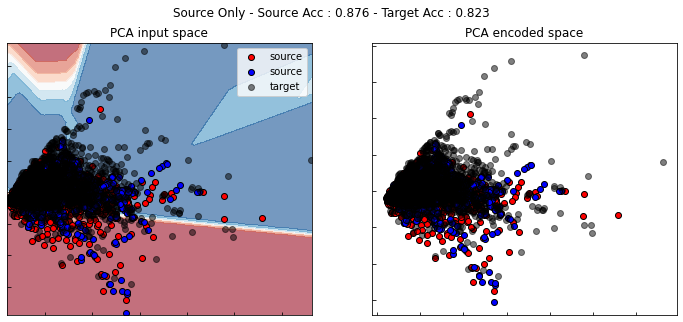

In [ ]:
show_results(sa, True)

fMMD

In [ ]:
fmmd = fMMD(estimator=get_task(),
             Xt=Xt, kernel="linear", loss="bce", optimizer=Adam(0.001, beta_1=0.5),random_state=0, verbose=0)
fmmd.fit(Xs, ys, epochs=800, batch_size=34, verbose=0);

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1503
           1       0.64      0.84      0.73       457

    accuracy                           0.85      1960
   macro avg       0.79      0.85      0.81      1960
weighted avg       0.87      0.85      0.86      1960

ok
Accuracy, source : 0.911890
Balanced accuracy, source : 0.911890
Precision, source: 0.896851
Recall, source: 0.930838
F1, source: 0.913529
Area under curve (auc):, source: 0.911890
Accuracy, target : 0.851020
Balanced accuracy, target : 0.848038
Precision, target: 0.636364
Recall, target: 0.842451
F1, target: 0.725047
Area under curve (auc):, target: 0.848038


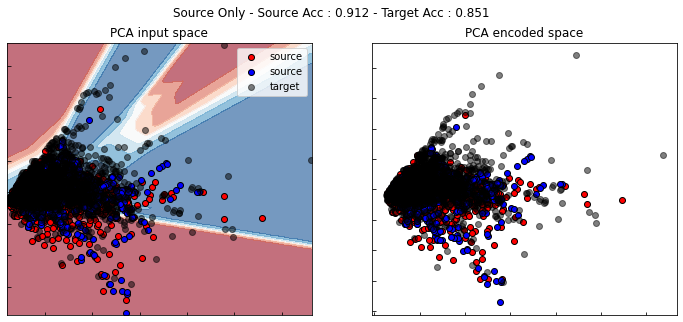

In [ ]:
show_results(fmmd, True)

KMM

In [ ]:
kmm = KMM(
    estimator=get_task(),
    Xt=Xt,
    gamma=1.,     # Bandwidth of the kernel
    loss="bce", optimizer=Adam(0.001, beta_1=0.5),
    verbose=0,
    random_state=0
)

In [ ]:
# Fit the model.
kmm.fit(Xs, ys, epochs=800, batch_size=34, verbose=0);

# Get the score on target data
kmm.score(Xt, yt)

1/1 [==============================] - 0s 83ms/step - loss: 0.6216


0.6216276288032532

In [ ]:
#show_results(kmm, True)

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1503
           1       0.66      0.81      0.73       457

    accuracy                           0.86      1960
   macro avg       0.80      0.84      0.82      1960
weighted avg       0.87      0.86      0.86      1960

ok
Accuracy, source : 0.876125
Balanced accuracy, source : 0.876125
Precision, source: 0.900605
Recall, source: 0.845571
F1, source: 0.872221
Area under curve (auc):, source: 0.876125
Accuracy, target : 0.858673
Balanced accuracy, target : 0.842369
Precision, target: 0.660142
Recall, target: 0.811816
F1, target: 0.728165
Area under curve (auc):, target: 0.842369


AttributeError: ignored

TCA

In [ ]:
from adapt.feature_based import TCA

In [ ]:
tca = TCA(estimator=get_task(), Xt=Xt, n_components=1, mu=0.1, 
            kernel="rbf", gamma=0.1,loss="bce", optimizer=Adam(0.001, beta_1=0.5),
verbose=0, random_state=0)
tca.fit(Xs, ys, epochs=800, batch_size=34, verbose=0);
tca.score(Xt, yt) 

1/1 [==============================] - 0s 107ms/step - loss: 0.6890


0.689023494720459

In [ ]:
#show_results(tca, True)

              precision    recall  f1-score   support

           0       0.82      0.55      0.66      1503
           1       0.29      0.61      0.39       457

    accuracy                           0.56      1960
   macro avg       0.56      0.58      0.53      1960
weighted avg       0.70      0.56      0.60      1960

ok
Accuracy, source : 0.579820
Balanced accuracy, source : 0.579820
Precision, source: 0.591726
Recall, source: 0.514922
F1, source: 0.550659
Area under curve (auc):, source: 0.579820
Accuracy, target : 0.564286
Balanced accuracy, target : 0.579607
Precision, target: 0.291710
Recall, target: 0.608315
F1, target: 0.394326
Area under curve (auc):, target: 0.579607


ValueError: ignored

<a name="DANN"></a>
 [DANN](https://adapt-python.github.io/adapt/generated/adapt.feature_based.DANN.html) lambda 1.0

In [ ]:
dann = DANN(task=get_task(), loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, lambda_=1., metrics=["acc"], random_state=0)


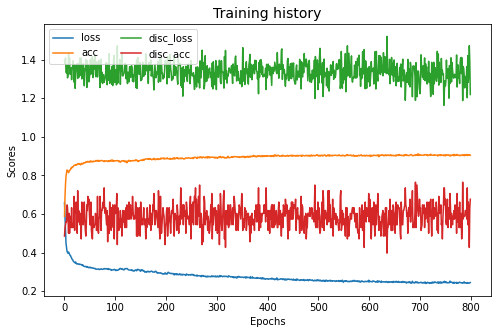

In [ ]:
dann.fit(Xs, ys, Xt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(dann.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1503
           1       0.54      0.89      0.67       457

    accuracy                           0.80      1960
   macro avg       0.75      0.83      0.76      1960
weighted avg       0.86      0.80      0.81      1960

Accuracy, target : 0.798469
Balanced accuracy, target : 0.832048
Precision, target: 0.541005
Recall, target: 0.894967
F1, target: 0.674361
62/62 [==============================] - 0s 1ms/step


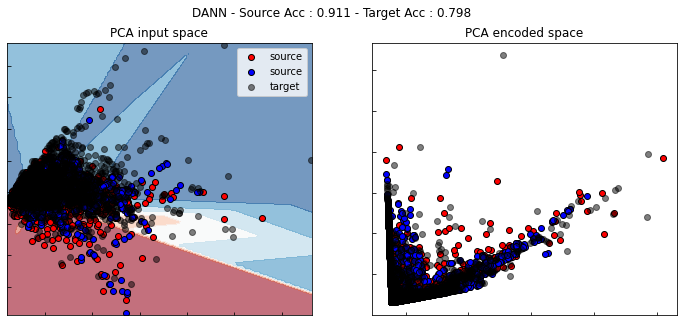

In [ ]:
show_results(dann)

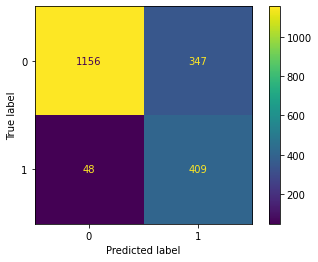

In [ ]:
ys_pred = dann.predict(Xs)
yt_pred = dann.predict(Xt)
cms = confusion_matrix(yt, yt_pred>0.5)
cm_display = ConfusionMatrixDisplay(cms).plot()

In [ ]:
dann.score(Xt, yt)

1/1 [==============================] - 0s 126ms/step - loss: 0.5776 - acc: 0.7985


0.5776063799858093

<a name="ADDA"></a>
 [ADDA](https://adapt-python.github.io/adapt/generated/adapt.feature_based.ADDA.html)

In [ ]:
adda = ADDA(task=get_task(),
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

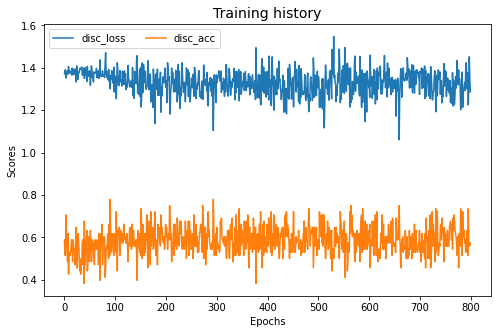

In [ ]:
adda.fit(Xs, ys, Xt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(adda.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1503
           1       0.47      0.79      0.59       457

    accuracy                           0.74      1960
   macro avg       0.70      0.76      0.70      1960
weighted avg       0.82      0.74      0.76      1960

Accuracy, target : 0.744898
Balanced accuracy, target : 0.762092
Precision, target: 0.472042
Recall, target: 0.794311
F1, target: 0.592170
62/62 [==============================] - 0s 1ms/step


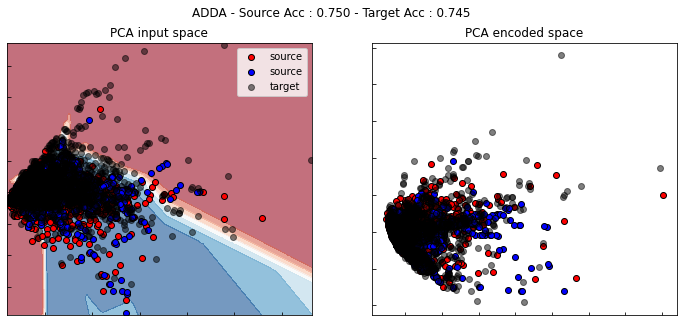

In [ ]:
show_results(adda)

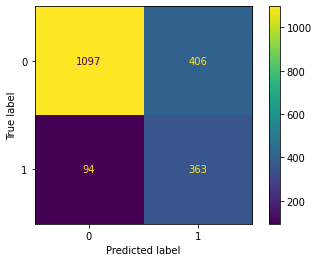

In [ ]:
ys_pred = adda.predict(Xs)
yt_pred = adda.predict(Xt)
cms = confusion_matrix(yt, yt_pred>0.5)
cm_display = ConfusionMatrixDisplay(cms).plot()

In [ ]:
adda.score(Xt, yt)

1/1 [==============================] - 0s 213ms/step - loss: 0.9118 - acc: 0.7449


0.9117503762245178

 CORAL

In [ ]:
coral = CORAL(estimator=get_task(), lambda_=0.,
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

Fit transform...
Previous covariance difference: 0.309190
New covariance difference: 0.000000
Fit Estimator...


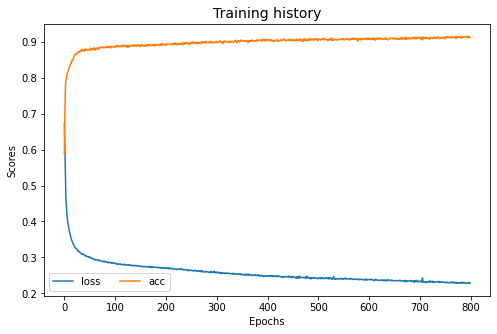

In [ ]:
coral.fit(Xs, ys, Xt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(coral.estimator_.history.history).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1503
           1       0.54      0.90      0.68       457

    accuracy                           0.80      1960
   macro avg       0.75      0.84      0.77      1960
weighted avg       0.87      0.80      0.81      1960

Accuracy, target : 0.800000
Balanced accuracy, target : 0.836091
Precision, target: 0.542707
Recall, target: 0.903720
F1, target: 0.678161


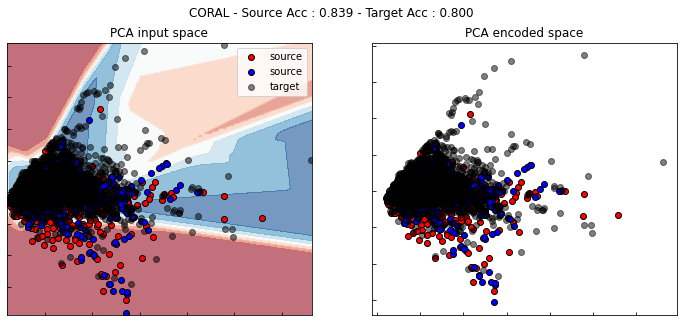

In [ ]:
show_results(coral)

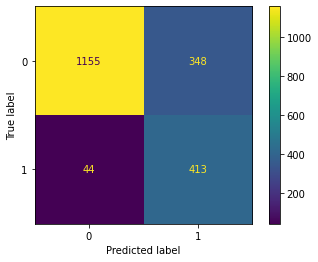

In [ ]:
ys_pred = coral.predict(Xs)
yt_pred = coral.predict(Xt)
cms = confusion_matrix(yt, yt_pred>0.5)
cm_display = ConfusionMatrixDisplay(cms).plot()

In [ ]:
coral.score(Xt, yt)

1/1 [==============================] - 0s 115ms/step - loss: 0.5811 - acc: 0.8000


0.5810760259628296

MDD

In [ ]:
mdd = MDD(task=get_task(),
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

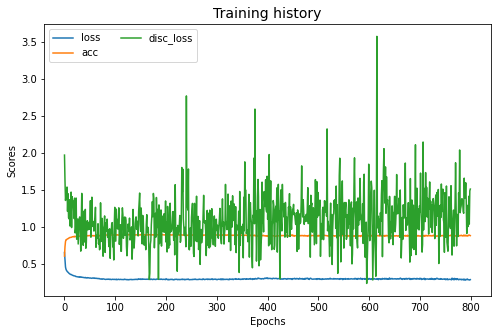

In [ ]:
mdd.fit(Xs, ys, Xt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(mdd.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1503
           1       0.63      0.79      0.70       457

    accuracy                           0.84      1960
   macro avg       0.78      0.82      0.80      1960
weighted avg       0.86      0.84      0.85      1960

Accuracy, target : 0.840816
Balanced accuracy, target : 0.823872
Precision, target: 0.625216
Recall, target: 0.792123
F1, target: 0.698842
62/62 [==============================] - 0s 1ms/step


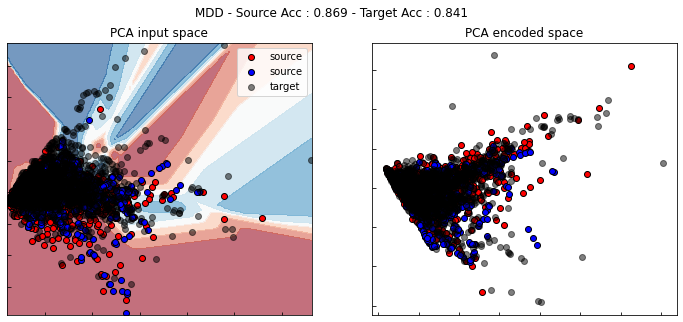

In [ ]:
show_results(mdd)

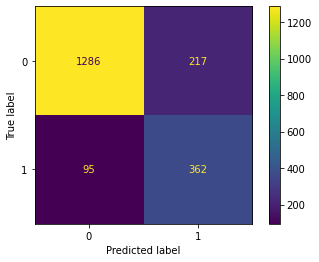

In [ ]:
ys_pred = mdd.predict(Xs)
yt_pred = mdd.predict(Xt)
cms = confusion_matrix(yt, yt_pred>0.5)
cm_display = ConfusionMatrixDisplay(cms).plot()

In [ ]:
mdd.score(Xt,yt)

1/1 [==============================] - 0s 121ms/step - loss: 0.6702 - acc: 0.8408


0.6702030897140503

WDGRL

In [ ]:
wdgrl = WDGRL(task=get_task(None), gamma=0.,
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

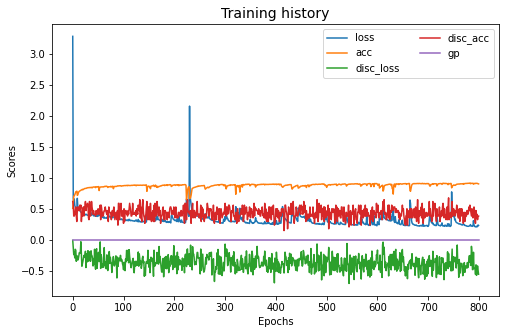

In [ ]:
wdgrl.fit(Xs, ys, Xt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(wdgrl.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.85      0.89      1503
           1       0.63      0.85      0.72       457

    accuracy                           0.85      1960
   macro avg       0.79      0.85      0.81      1960
weighted avg       0.87      0.85      0.85      1960

Accuracy, target : 0.846429
Balanced accuracy, target : 0.846567
Precision, target: 0.626214
Recall, target: 0.846827
F1, target: 0.720000
62/62 [==============================] - 0s 1ms/step


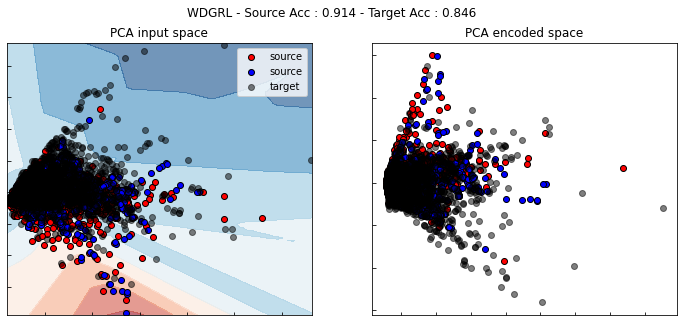

In [ ]:
show_results(wdgrl)

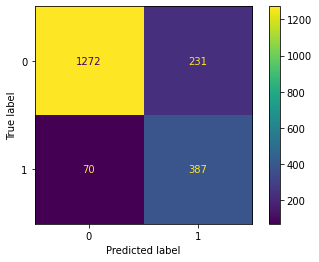

In [ ]:
ys_pred = wdgrl.predict(Xs)
yt_pred = wdgrl.predict(Xt)
cms = confusion_matrix(yt, yt_pred>0.5)
cm_display = ConfusionMatrixDisplay(cms).plot()

In [ ]:
wdgrl.score(Xt,yt)

1/1 [==============================] - 0s 133ms/step - loss: 0.7383 - acc: 0.8464


0.7383052110671997

CDAN

In [ ]:
cdan = CDAN(task=get_task(), entropy=True,
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, random_state=0) 

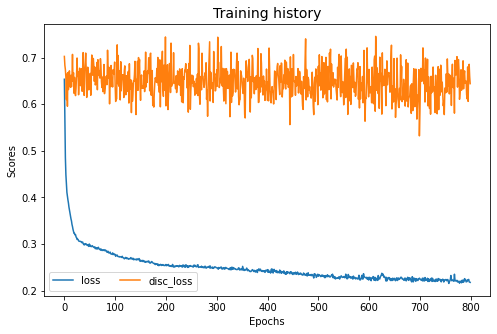

In [ ]:
cdan.fit(Xs, ys, Xt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(cdan.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1503
           1       0.59      0.86      0.70       457

    accuracy                           0.83      1960
   macro avg       0.77      0.84      0.79      1960
weighted avg       0.87      0.83      0.84      1960

Accuracy, target : 0.828571
Balanced accuracy, target : 0.840254
Precision, target: 0.590705
Recall, target: 0.862144
F1, target: 0.701068
62/62 [==============================] - 0s 1ms/step


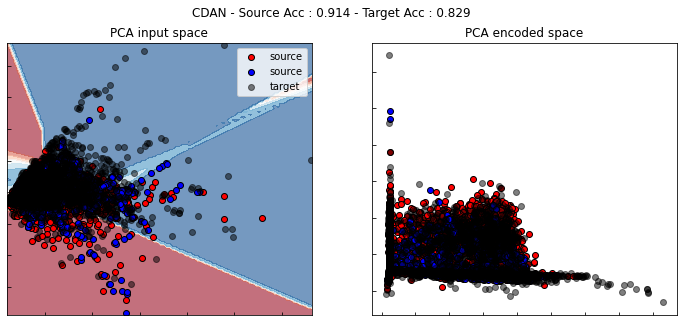

In [ ]:
show_results(cdan)

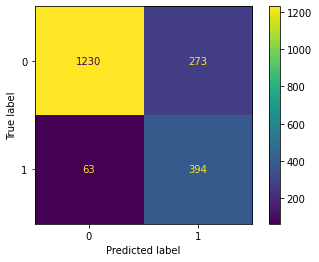

In [ ]:
ys_pred = cdan.predict(Xs)
yt_pred = cdan.predict(Xt)
cms = confusion_matrix(yt, yt_pred>0.5)
cm_display = ConfusionMatrixDisplay(cms).plot()

In [ ]:
cdan.score(Xt,yt)

1/1 [==============================] - 0s 113ms/step - loss: 0.5868


0.5868430137634277